In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to sketches folder
SKETCHES_FOLDER = 'dataset_quickdraw/sketches/sketches'

# List the first 10 .npz files (classes)
all_npz_files = sorted([f for f in os.listdir(SKETCHES_FOLDER) if f.endswith('.npz')])
selected_npz_files = all_npz_files[:10]
print("Selected classes:", selected_npz_files)

# Load one .npz file (e.g., the first one)
sample_class_file = os.path.join(SKETCHES_FOLDER, selected_npz_files[0])
data = np.load(sample_class_file, allow_pickle=True, encoding='latin1')

# Display the available keys to know the contents of the npz file
print("Keys in the file:", data.files)

# Show how many sketches are in each split
for split in ['train', 'valid', 'test']:
    if split in data:
        print(f"{split.capitalize()} data shape: {data[split].shape}")


Selected classes: ['The Eiffel Tower.npz', 'The Great Wall of China.npz', 'The Mona Lisa.npz', 'aircraft carrier.npz', 'airplane.npz', 'alarm clock.npz', 'ambulance.npz', 'angel.npz', 'animal migration.npz', 'ant.npz']
Keys in the file: ['test', 'train', 'valid']
Train data shape: (70000,)
Valid data shape: (2500,)
Test data shape: (2500,)


In [2]:
# 3. Visualize a few samples from the 'train' split
def plot_sketches(sketches, num=5, title='Sketch'):
    plt.figure(figsize=(10, 2))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(sketches[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


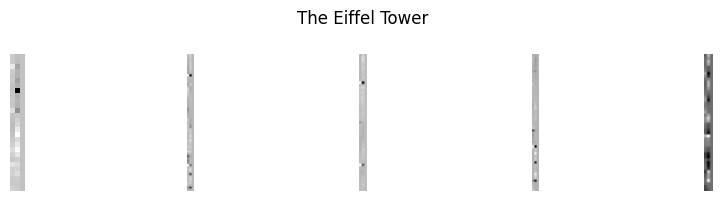

In [3]:
# Extract 'train' sketches and plot
train_sketches = data['train']
plot_sketches(train_sketches, num=5, title=selected_npz_files[0].replace('.npz', ''))

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def draw_sketch(sketch):
    """
    Draws a sketch from a stroke-3 format array of shape (n, 3).
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.axis('off')

    x, y = 0, 0
    for i in range(len(sketch)):
        dx, dy, pen = sketch[i]
        new_x, new_y = x + dx, y + dy
        if pen == 0:
            ax.plot([x, new_x], [y, new_y], 'k-', linewidth=1)
        x, y = new_x, new_y

    plt.show()


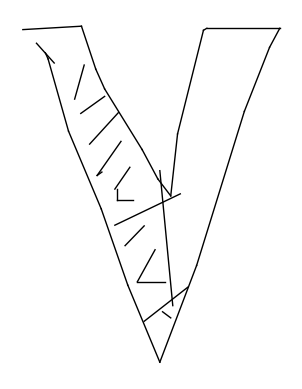

In [5]:
draw_sketch(train_sketches[10])

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def sketch_to_image(sketch, image_size=28, padding=2):
    """
    Converts a stroke-3 sketch to a 28x28 grayscale image.
    sketch: (n_points, 3) numpy array
    image_size: size of the output image
    padding: white padding around the sketch
    Returns: 28x28 numpy image array (dtype=float32, values between 0 and 1)
    """
    # Convert relative strokes to absolute coordinates (this conversion is very important)
    x, y = 0, 0
    abs_coords = []
    for dx, dy, pen in sketch:
        x += dx
        y += dy
        abs_coords.append((x, y, pen))
    
    # Separate strokes into pen-down segments
    strokes = []
    current_stroke = []
    for x, y, pen in abs_coords:
        if pen == 0:
            current_stroke.append((x, y))
        elif pen == 1:
            if current_stroke:
                strokes.append(current_stroke)
                current_stroke = []
        elif pen == 2:
            break  # end of drawing
    
    if current_stroke:
        strokes.append(current_stroke)
    
    # Get bounding box for normalization
    all_points = [pt for stroke in strokes for pt in stroke]
    xs, ys = zip(*all_points)
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    # Scale factor to fit sketch into image_size x image_size
    scale = (image_size - 2 * padding) / max(max_x - min_x, max_y - min_y + 1e-5)
    
    # Create blank image and draw strokes
    img = Image.new('L', (image_size, image_size), 'white')  # L = grayscale
    draw = ImageDraw.Draw(img)
    for stroke in strokes:
        scaled = [((x - min_x) * scale + padding, (y - min_y) * scale + padding) for x, y in stroke]
        draw.line(scaled, fill=0, width=1)
    
    return np.array(img, dtype=np.float32) / 255.0  # Normalize to 0–1


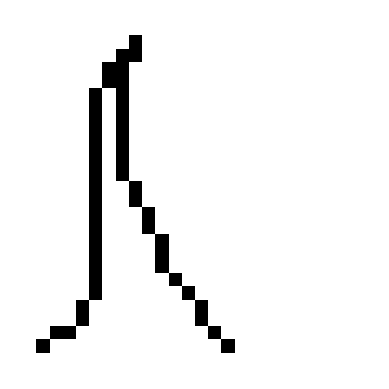

In [8]:
image = sketch_to_image(train_sketches[0])
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


In [19]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(sketches_folder, selected_classes, samples_per_class=1000):
    """
    Load and preprocess data from multiple classes
    - Defines load_and_preprocess_data function
    - Creates train/val splits
    - Prints dataset information
    """
    X = []  # Will store all images
    y = []  # Will store corresponding labels
    
    for class_idx, class_file in enumerate(selected_classes):
        # Load the .npz file
        data = np.load(os.path.join(sketches_folder, class_file), 
                      allow_pickle=True, encoding='latin1')
        
        # Get training sketches
        sketches = data['train']
        
        # Convert first n sketches to images
        for i in range(min(samples_per_class, len(sketches))):
            image = sketch_to_image(sketches[i])
            X.append(image)
            y.append(class_idx)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Reshape to (n_samples, height, width, channels)
    X = X.reshape(-1, 28, 28, 1)
    
    return X, y


In [20]:
# Load and preprocess all classes
X, y = load_and_preprocess_data(SKETCHES_FOLDER, selected_npz_files)

# Create train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print dataset information
print("Dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")

# Print class distribution
print("\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for class_idx, count in zip(unique, counts):
    print(f"{selected_npz_files[class_idx]}: {count}")

Dataset shapes:
X_train: (8000, 28, 28, 1)
X_val: (2000, 28, 28, 1)
y_train: (8000,)
y_val: (2000,)

Class distribution in training set:
The Eiffel Tower.npz: 800
The Great Wall of China.npz: 800
The Mona Lisa.npz: 800
aircraft carrier.npz: 800
airplane.npz: 800
alarm clock.npz: 800
ambulance.npz: 800
angel.npz: 800
animal migration.npz: 800
ant.npz: 800


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_sketch_classifier(input_shape=(28, 28, 1), num_classes=10):
    """
    Creates a CNN model optimized for sketch classification
    """
    model = models.Sequential([
        # Remove the Reshape layer and fix the input shape
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Compile and train the model
def compile_and_train(model, X_train, y_train, X_val, y_val):
    """
    Compiles and trains the model with appropriate settings
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ]
    )
    
    return history

In [26]:
# Create the model
model = create_sketch_classifier(num_classes=10)  # 10 classes as per selected_npz_files
model.summary()  # Display model architecture

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,082 (2.64 MB)

 Trainable params: 689,610 (2.63 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [27]:
# Train the model
history = compile_and_train(model, X_train, y_train, X_val, y_val)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 228ms/step - accuracy: 0.5182 - loss: 1.4847 - val_accuracy: 0.1000 - val_loss: 6.2960 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - accuracy: 0.6656 - loss: 0.9963 - val_accuracy: 0.1015 - val_loss: 7.2925 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 199ms/step - accuracy: 0.7197 - loss: 0.8481 - val_accuracy: 0.1935 - val_loss: 4.5654 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - accuracy: 0.7450 - loss: 0.7671 - val_accuracy: 0.4150 - val_loss: 1.9536 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.7626 - loss: 0.7122 - val_accuracy: 0.7160 - val_loss: 0.8416 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.7866 - loss: 0.6442 - val_accuracy: 0.7880 - val_loss: 0.6537 - learning_rate: 0.0010
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 155ms/step - accuracy: 0.7

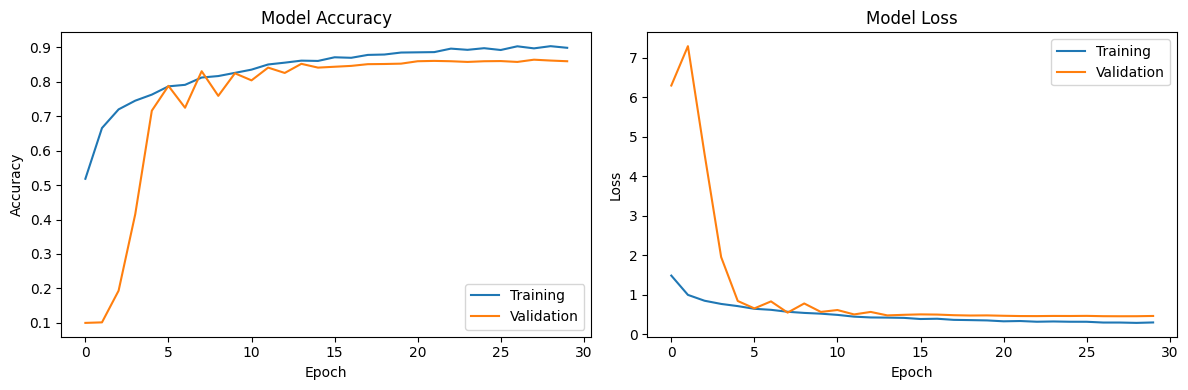

In [28]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()